### Gesture Index Mapping

| Index | Gesture | Description                        |
|-------|---------|------------------------------------|
| 0     | LP      | Lateral prehension                 |
| 1     | TA      | Thumb adduction                    |
| 2     | TLFO    | Thumb and little finger opposition |
| 3     | TIFO    | Thumb and index finger opposition  |
| 4     | TLFE    | Thumb and little finger extension  |
| 5     | TIFE    | Thumb and index finger extension   |
| 6     | IMFE    | Index and middle finger extension  |
| 7     | LFE     | Little finger extension            |
| 8     | IFE     | Index finger extension             |
| 9     | TE      | Thumb extension                    |
| 10    | WF      | Wrist flexion                      |
| 11    | WE      | Wrist extension                    |
| 12    | FP      | Forearm pronation                  |
| 13    | FS      | Forearm supination                 |
| 14    | HO      | Hand open                          |
| 15    | HC      | Hand close                         |
| 16    | REST    | Rest / No movement                 |
- The order of the 16 gestures was randomized and a resting (REST) trial was collected after all 16 gestures were performed once. 
- A ten-seconds relaxing period was provided between each trial. 

## 2.1 - Basic structure comfirmation
- verify sampling rate for Nyquist limit (assume T = 5sec and f_s = N/T (N = # of samples, T = period))
- check for signal amplitude
    - Amplitude sanity: robust P5–P95, MAD, RMS.
    - Clipping/saturation: % samples near edge, flat runs.
- Welch PSD: main energy 20–450 Hz.
    - Powerline: check 50/60 Hz residuals (and harmonics).
    - Usable band fraction: ≥70% of power in 20–450 Hz.
- Acceptance gates
    - Hard fail: wrong fs/duration, NaN/Inf, clipping >0.1%, missing channels.
    - Soft flag: low band power (<70%), poor notch, high trial variability.


Found 129 .mat files
Selected file: session3_participant34.mat
Visualizing Gesture 7(Trial 4)
Forearm Sampling Rate: 2048.0 Hz | Wrist Sampling Rate: 2048.0 Hz


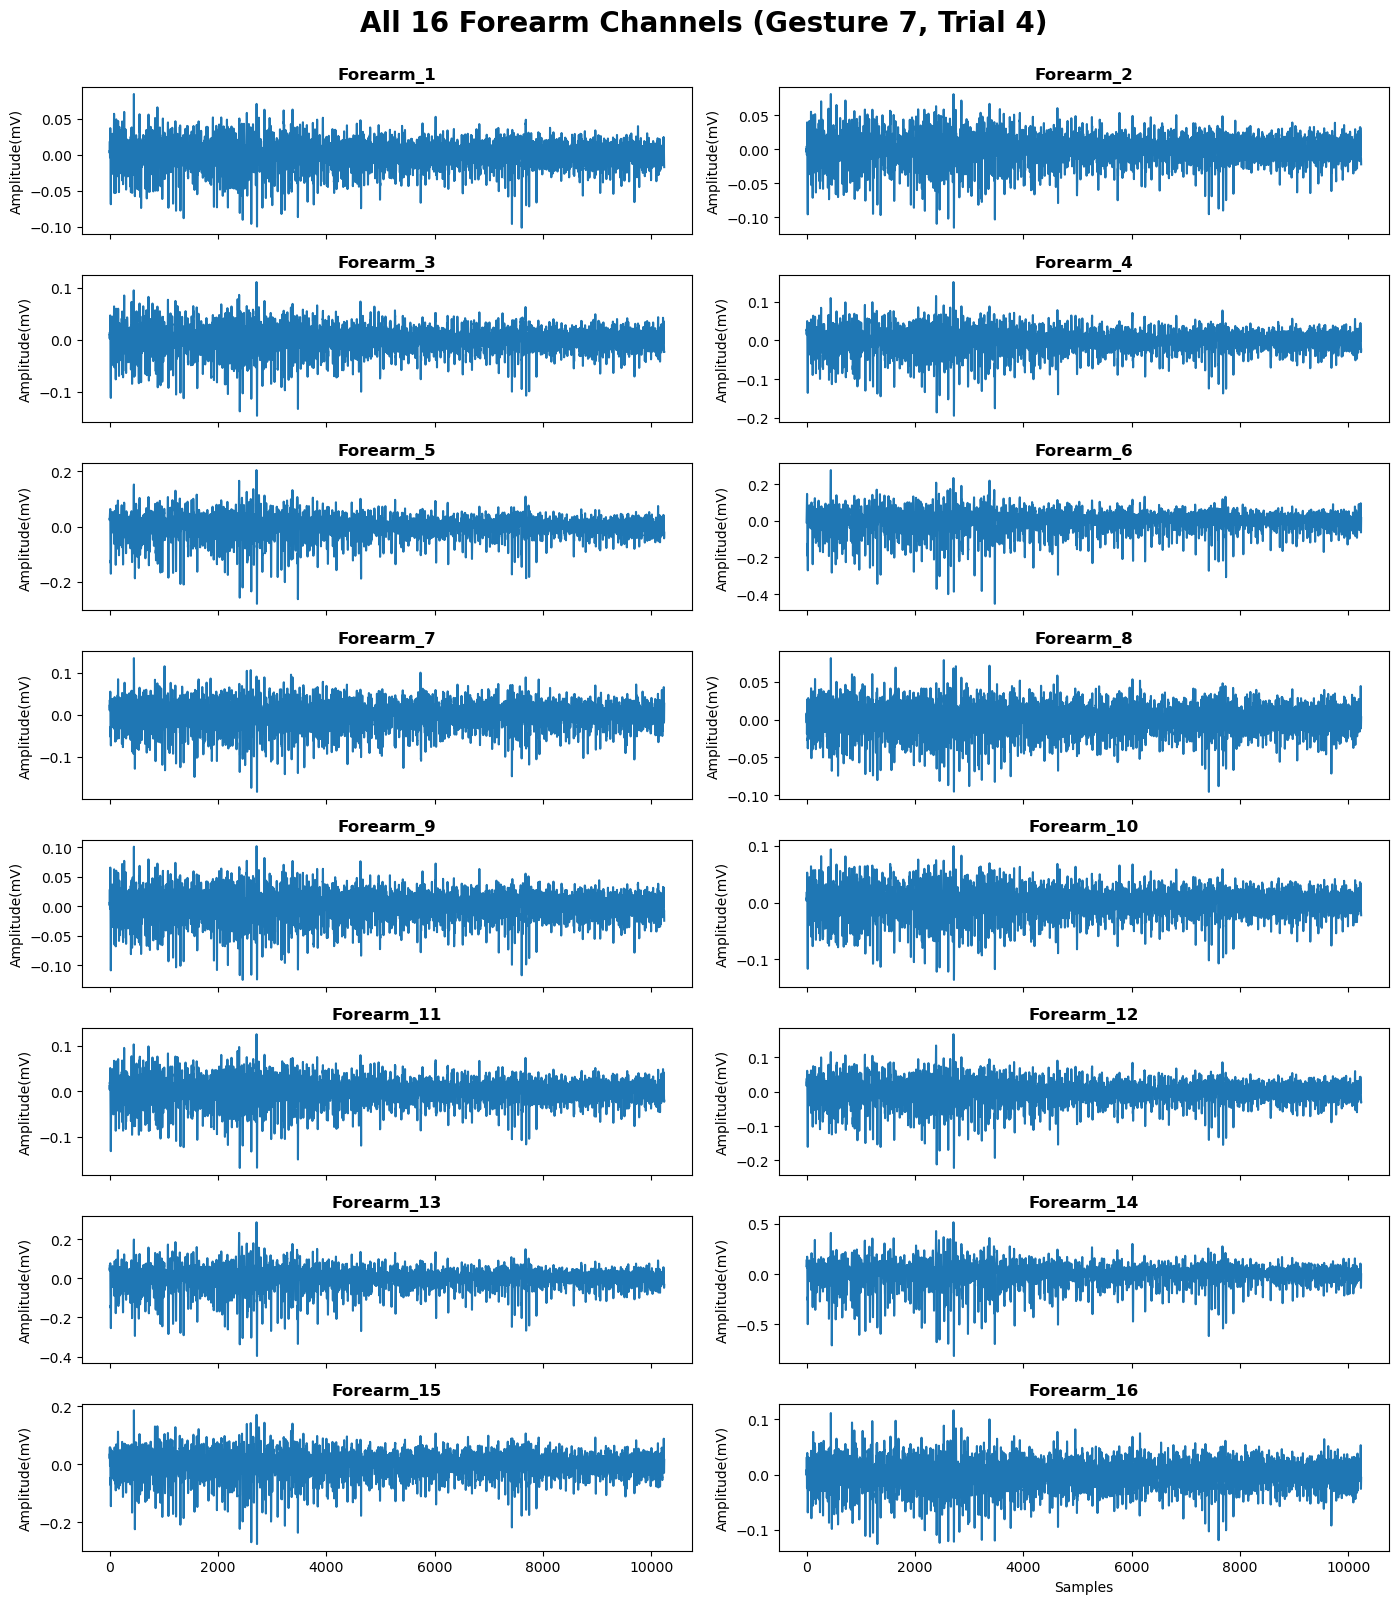

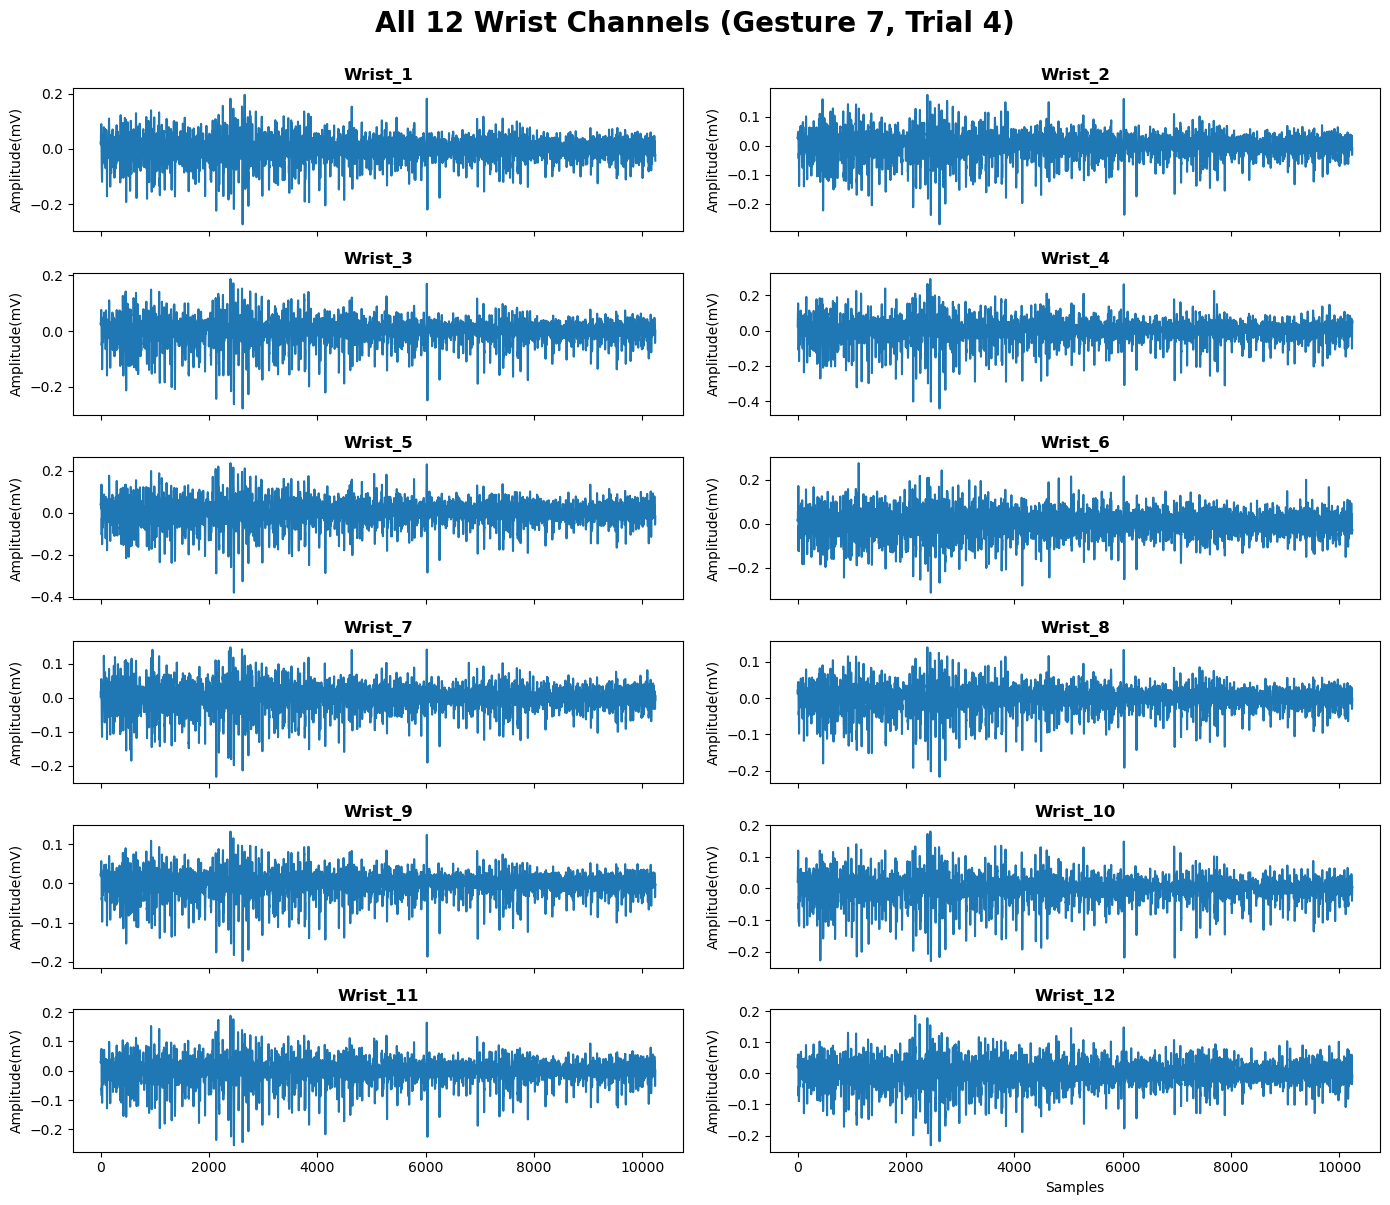

In [2]:
import numpy as np
import scipy.io as sio
from pathlib import Path
import matplotlib.pyplot as plt
import random
from natsort import natsorted


# Set all EMG folders here
folders = [
    "/Users/jasonwang/Desktop/Wearable/EMG_Project/grabmyo_1.1.0/OutputBM/Session1_converted",
    "/Users/jasonwang/Desktop/Wearable/EMG_Project/grabmyo_1.1.0/OutputBM/Session2_converted",
    "/Users/jasonwang/Desktop/Wearable/EMG_Project/grabmyo_1.1.0/OutputBM/Session3_converted"
 ]

# Collect all .mat files
mat_files = []
for folder in folders:
    mat_files.extend(natsorted(list(Path(folder).glob("*.mat"))))

print(f"\nFound {len(mat_files)} .mat files")

# Choose what file to load:
sample_file = random.choice(mat_files)                                              # Option 1: Random file
# sample_file = mat_files[0]                                                        # Option 2: By file index
# sample_file = [f for f in mat_files if "session1_participant1.mat" in str(f)]     # Option 3: By name

print(f"Selected file: {sample_file.name}")
data = sio.loadmat(sample_file)

# Total number of trials and gestures
num_trials = 7
num_gestures = 17

# Option to choose random or specific indices
use_random = True  # Set to False to assign specific indices
if use_random: #randomly select a trial and gesture
    trial_idx = random.randint(0, num_trials - 1)
    gesture_idx = random.randint(0, num_gestures - 1)
else:
    trial_idx = 0  # Example: First trial
    gesture_idx = 16  # Example: 17th gesture (REST)
    # Ensure indices are within valid range
    assert 0 <= trial_idx < num_trials, f"trial_idx must be between 0 and {num_trials - 1}"
    assert 0 <= gesture_idx < num_gestures, f"gesture_idx must be between 0 and {num_gestures - 1}"   

# Load forearm and wrist data for the selected trial and gesture
forearm = data['DATA_FOREARM'][trial_idx, gesture_idx]
wrist = data['DATA_WRIST'][trial_idx, gesture_idx]
channels = [f'Forearm_{i+1}' for i in range(16)] + [f'Wrist_{i+1}' for i in range(12)]

print(f"Visualizing Gesture {gesture_idx}(Trial {trial_idx + 1})")

# Generalized function to calculate sampling rate and time axis
def calculate_fs_and_time(data, T):
    N = data.shape[0]  # Number of samples
    fs = N / T  # Sampling rate
    time = np.linspace(0, T, N)  # Time axis
    return fs, time

# Duration of the recording
T = 5  # Duration in seconds

# Calculate sampling rate and time axis for forearm
fs_forearm, time_forearm = calculate_fs_and_time(forearm, T)

# Calculate sampling rate and time axis for wrist
fs_wrist, time_wrist = calculate_fs_and_time(wrist, T)
print(f"Forearm Sampling Rate: {fs_forearm} Hz | Wrist Sampling Rate: {fs_wrist} Hz")

# Plot all 16 forearm channels in subplots
fig, axes = plt.subplots(8, 2, figsize=(14, 16), sharex=True)
axes = axes.flatten()
for i in range(16):
    axes[i].plot(forearm[:, i])
    axes[i].set_title(channels[i], fontweight='bold')
    axes[i].set_ylabel('Amplitude(mV)')
axes[-1].set_xlabel('Samples')
plt.suptitle(f'All 16 Forearm Channels (Gesture {gesture_idx}, Trial {trial_idx + 1})', y=1, fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

# Plot all 12 wrist channels in subplots
fig, axes = plt.subplots(6, 2, figsize=(14, 12), sharex=True)
axes = axes.flatten()
for i in range(12):
    axes[i].plot(wrist[:, i])
    axes[i].set_title(channels[i + 16], fontweight='bold')
    axes[i].set_ylabel('Amplitude(mV)')
axes[-1].set_xlabel('Samples')
plt.suptitle(f'All 12 Wrist Channels (Gesture {gesture_idx}, Trial {trial_idx + 1})', y=1, fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()


In [3]:
from scipy.stats import median_abs_deviation
import pandas as pd

print(f"Selected file: {sample_file.name}")

print(f"Visualizing Gesture {gesture_idx}(Trial {trial_idx + 1})")

# Function to calculate P5-P95, MAD, and RMS
def calculate_signal_metrics(data):
    p5 = float(np.percentile(data, 5))
    p95 = float(np.percentile(data, 95))
    mad = float(median_abs_deviation(data))
    rms = float(np.sqrt(np.mean(data**2)))
    return {'P5': p5, 'P95': p95, 'MAD': mad, 'RMS': rms}

# Calculate and display metrics for forearm channels
forearm_metrics = [calculate_signal_metrics(forearm[:, ch]) for ch in range(forearm.shape[1])]
forearm_df = pd.DataFrame(forearm_metrics)
forearm_df.index = [f"Forearm_{i+1}" for i in range(forearm.shape[1])]
display(forearm_df.style.format("{:.3f}").background_gradient(cmap="Greens"))

# Calculate and display metrics for wrist channels
wrist_metrics = [calculate_signal_metrics(wrist[:, ch]) for ch in range(wrist.shape[1])]
wrist_df = pd.DataFrame(wrist_metrics)
wrist_df.index = [f"Wrist_{i+1}" for i in range(wrist.shape[1])]
display(wrist_df.style.format("{:.3f}").background_gradient(cmap="Blues"))

Selected file: session3_participant34.mat
Visualizing Gesture 7(Trial 4)


,P5,P95,MAD,RMS
Forearm_1,-0.034,0.029,0.011,0.019
Forearm_2,-0.037,0.032,0.012,0.021
Forearm_3,-0.043,0.037,0.014,0.025
Forearm_4,-0.054,0.045,0.017,0.031
Forearm_5,-0.073,0.059,0.022,0.042
Forearm_6,-0.105,0.079,0.028,0.058
Forearm_7,-0.058,0.047,0.020,0.032
Forearm_8,-0.033,0.029,0.012,0.019
Forearm_9,-0.042,0.036,0.014,0.024
Forearm_10,-0.044,0.037,0.014,0.025


,P5,P95,MAD,RMS
Wrist_1,-0.076,0.065,0.023,0.044
Wrist_2,-0.076,0.064,0.023,0.043
Wrist_3,-0.080,0.066,0.023,0.045
Wrist_4,-0.112,0.098,0.033,0.065
Wrist_5,-0.097,0.084,0.030,0.056
Wrist_6,-0.090,0.084,0.030,0.053
Wrist_7,-0.065,0.056,0.020,0.038
Wrist_8,-0.061,0.052,0.018,0.035
Wrist_9,-0.056,0.047,0.016,0.032
Wrist_10,-0.068,0.060,0.020,0.040


Selected file: session3_participant34.mat
Visualizing Gesture 7(Trial 4)


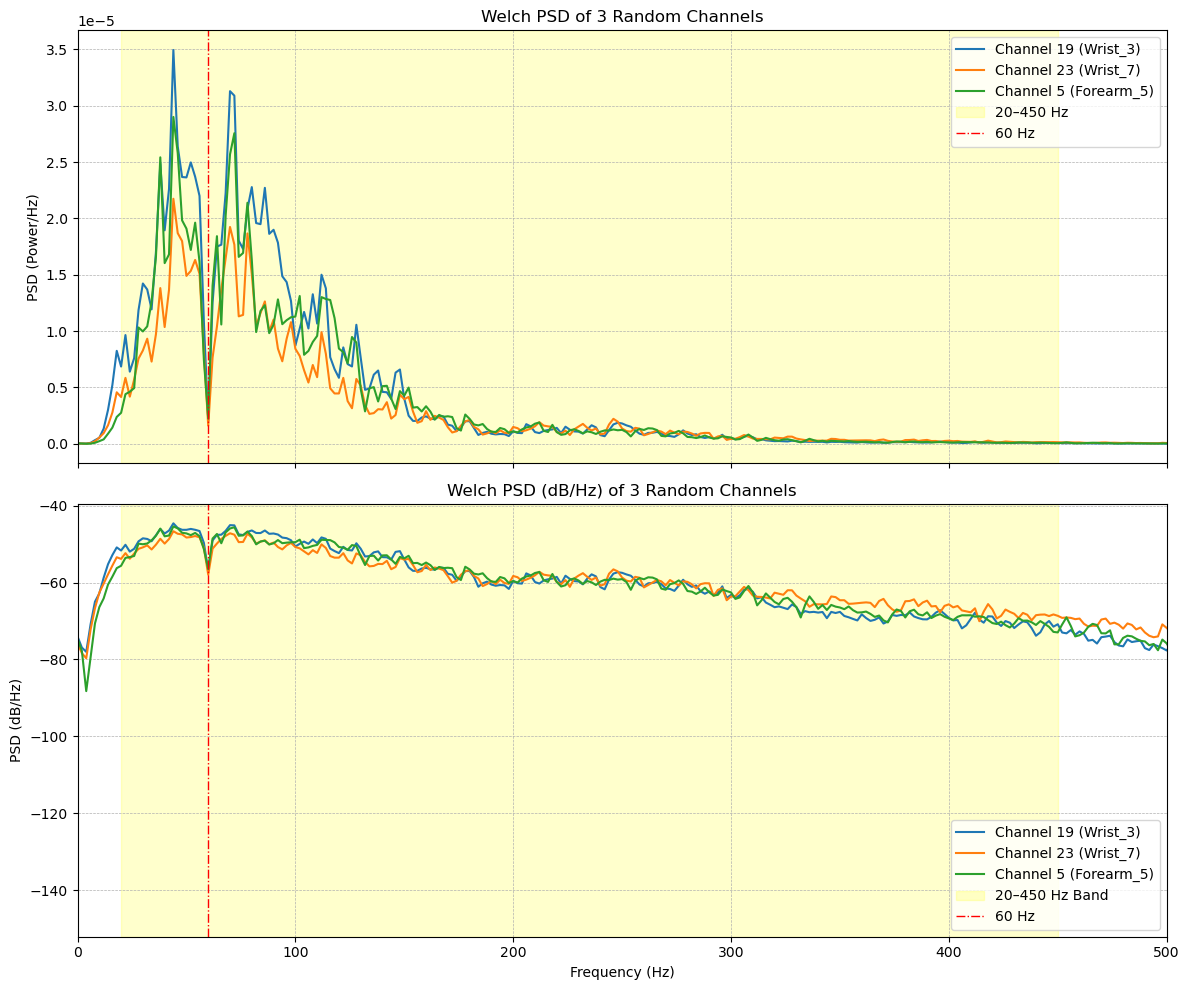

,Channel,Power_0_20Hz,Power_20_60Hz,Power_60_450Hz,MNF,MDF,UBF_20_450Hz
0,Forearm_1,5.64e-06,1.07e-04,2.66e-04,117.9,90.0,0.978
1,Forearm_2,6.06e-06,1.37e-04,3.21e-04,112.0,84.0,0.982
2,Forearm_3,5.16e-06,1.82e-04,4.36e-04,110.6,86.0,0.987
3,Forearm_4,6.90e-06,2.96e-04,6.54e-04,101.7,80.0,0.990
4,Forearm_5,1.09e-05,5.78e-04,1.22e-03,95.6,78.0,0.992
5,Forearm_6,1.94e-05,9.75e-04,2.46e-03,109.2,86.0,0.992
6,Forearm_7,1.60e-05,2.72e-04,7.80e-04,114.1,92.0,0.981
7,Forearm_8,5.79e-06,9.24e-05,2.75e-04,127.6,100.0,0.977
8,Forearm_9,5.78e-06,1.53e-04,4.27e-04,124.3,96.0,0.983
9,Forearm_10,5.41e-06,1.72e-04,4.46e-04,118.3,92.0,0.985


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import pandas as pd

print(f"Selected file: {sample_file.name}")

print(f"Visualizing Gesture {gesture_idx}(Trial {trial_idx + 1})")

# Combine forearm and wrist data for all 28 channels
all_channels = np.hstack([forearm, wrist])
fs = int(fs_forearm)  # Use forearm fs (should match wrist)

# 1. Randomly select x channels and plot their Welch PSD
x = 3  # Number of channels to plot
rand_channels = np.random.choice(28, x, replace=False)

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Top: Linear Power PSD
for idx, ch in enumerate(rand_channels):
    f, Pxx = welch(all_channels[:, ch], fs=fs, nperseg=1024)
    axes[0].plot(f, Pxx, label=f'Channel {ch+1} ({channels[ch]})')
axes[0].set_xlim(0, 500)
axes[0].set_ylabel('PSD (Power/Hz)')
axes[0].set_title(f'Welch PSD of {x} Random Channels')
axes[0].axvspan(20, 450, color='yellow', alpha=0.2, label='20–450 Hz')
axes[0].axvline(60, color='red', linestyle='-.', linewidth=1, label='60 Hz')
axes[0].grid(True, linestyle='--', linewidth=0.5)
axes[0].legend()

# Bottom: dB/Hz PSD
for idx, ch in enumerate(rand_channels):
    f, Pxx = welch(all_channels[:, ch], fs=fs, nperseg=1024)
    axes[1].plot(f, 10*np.log10(Pxx), label=f'Channel {ch+1} ({channels[ch]})')
axes[1].set_xlim(0, 500)
axes[1].set(xlabel='Frequency (Hz)', ylabel='PSD (dB/Hz)', 
            title=f'Welch PSD (dB/Hz) of {x} Random Channels')
axes[1].axvspan(20, 450, color='yellow', alpha=0.2, label='20–450 Hz Band')
axes[1].axvline(60, color='red', linestyle='-.', linewidth=1, label='60 Hz')
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].legend()

plt.tight_layout()
plt.show()

# 2. Compute power in bands and spectral metrics for all channels
band_edges = [(0, 20), (20, 60), (60, 450)]
metrics = []
for ch in range(28):
    f, Pxx = welch(all_channels[:, ch], fs=fs, nperseg=1024)
    df = f[1] - f[0]
    total_power = np.sum(Pxx) * df
    band_powers = []
    for low, high in band_edges:
        mask = (f >= low) & (f < high)
        band_power = np.sum(Pxx[mask]) * df
        band_powers.append(band_power)
    # UBF: fraction of power in 20–450 Hz
    ubf_mask = (f >= 20) & (f <= 450)
    ubf_power = np.sum(Pxx[ubf_mask]) * df
    ubf = ubf_power / total_power if total_power > 0 else np.nan
    # MNF: mean frequency
    mnf = np.sum(f * Pxx) / np.sum(Pxx)
    # MDF: median frequency
    cumsum = np.cumsum(Pxx)
    mdf = f[np.searchsorted(cumsum, cumsum[-1]/2)]
    metrics.append({
        'Channel': channels[ch],
        'Power_0_20Hz': band_powers[0],
        'Power_20_60Hz': band_powers[1],
        'Power_60_450Hz': band_powers[2],
        'MNF': mnf,
        'MDF': mdf,
        'UBF_20_450Hz': ubf
    })

# 3. Output as table
metrics_df = pd.DataFrame(metrics)
display(metrics_df.style.format({
    'Power_0_20Hz': '{:.2e}',
    'Power_20_60Hz': '{:.2e}',
    'Power_60_450Hz': '{:.2e}',
    'MNF': '{:.1f}',
    'MDF': '{:.1f}',
    'UBF_20_450Hz': '{:.3f}'
}).background_gradient(cmap='coolwarm'))

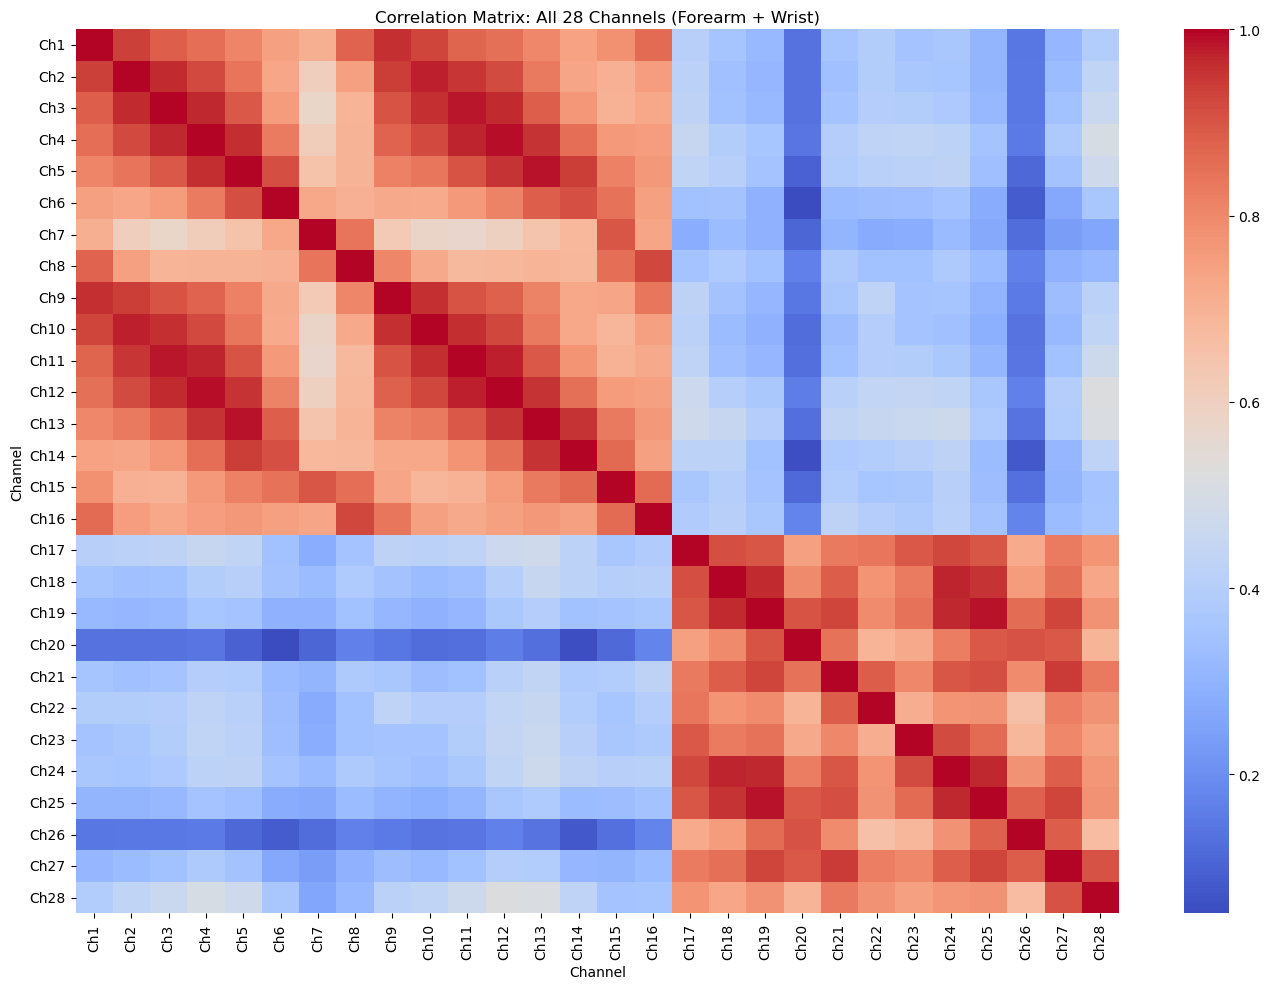

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Stack forearm and wrist channels
all_channels = np.hstack([forearm, wrist])  # shape: (samples, 28)

# Compute correlation matrix for all 28 channels
corr_matrix = np.corrcoef(all_channels, rowvar=False)  # shape: (28, 28)

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm',
            xticklabels=[f'Ch{i+1}' for i in range(28)],
            yticklabels=[f'Ch{i+1}' for i in range(28)])
plt.title('Correlation Matrix: All 28 Channels (Forearm + Wrist)')
plt.xlabel('Channel')
plt.ylabel('Channel')
plt.tight_layout()
plt.show()

## 2.2 - diff gesture comparison 
> Show that different gestures produce distinguishable muscle activity (same participants diff channel)

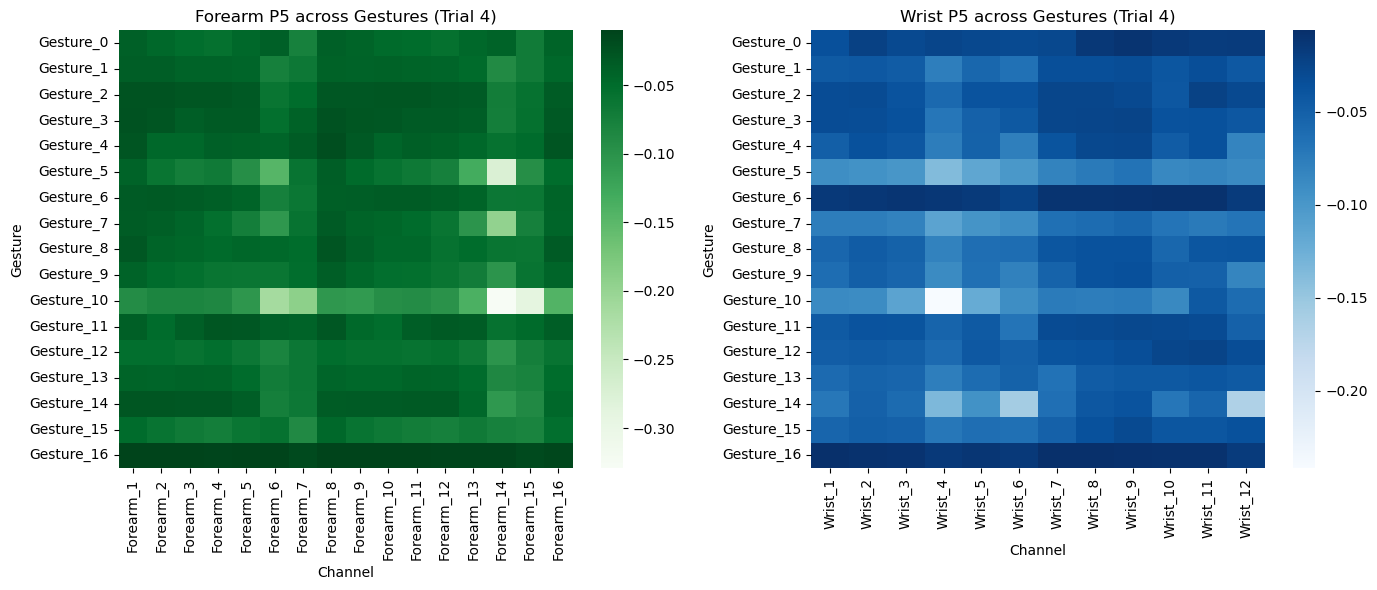

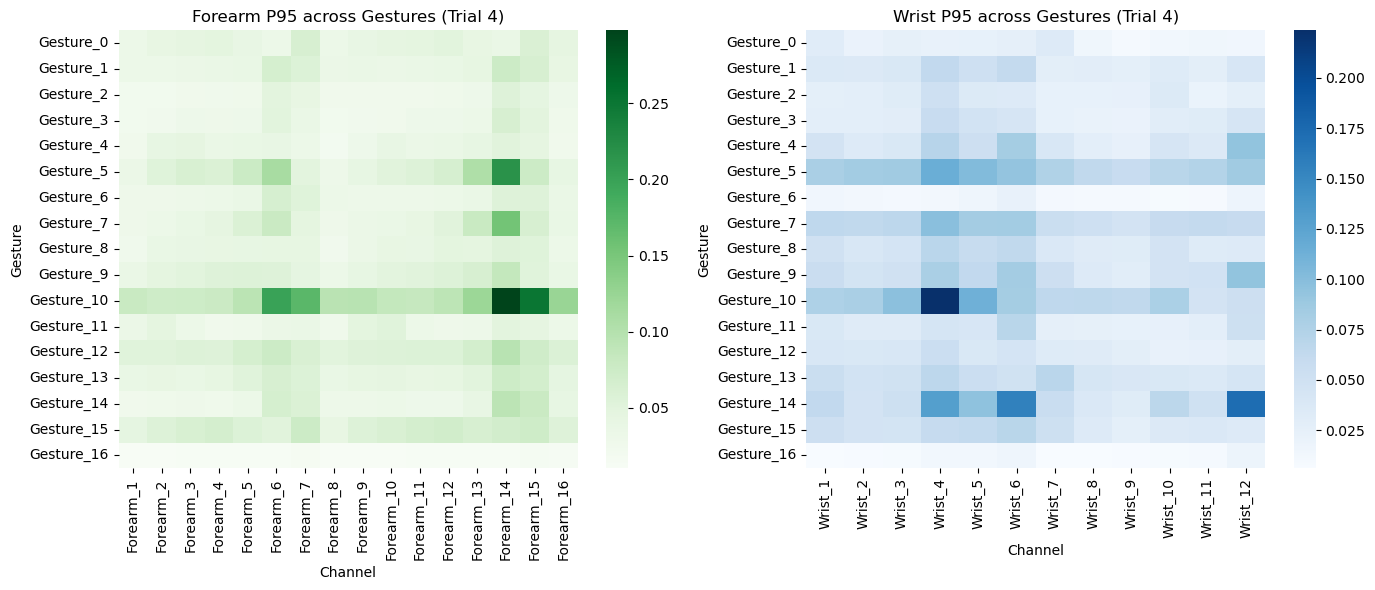

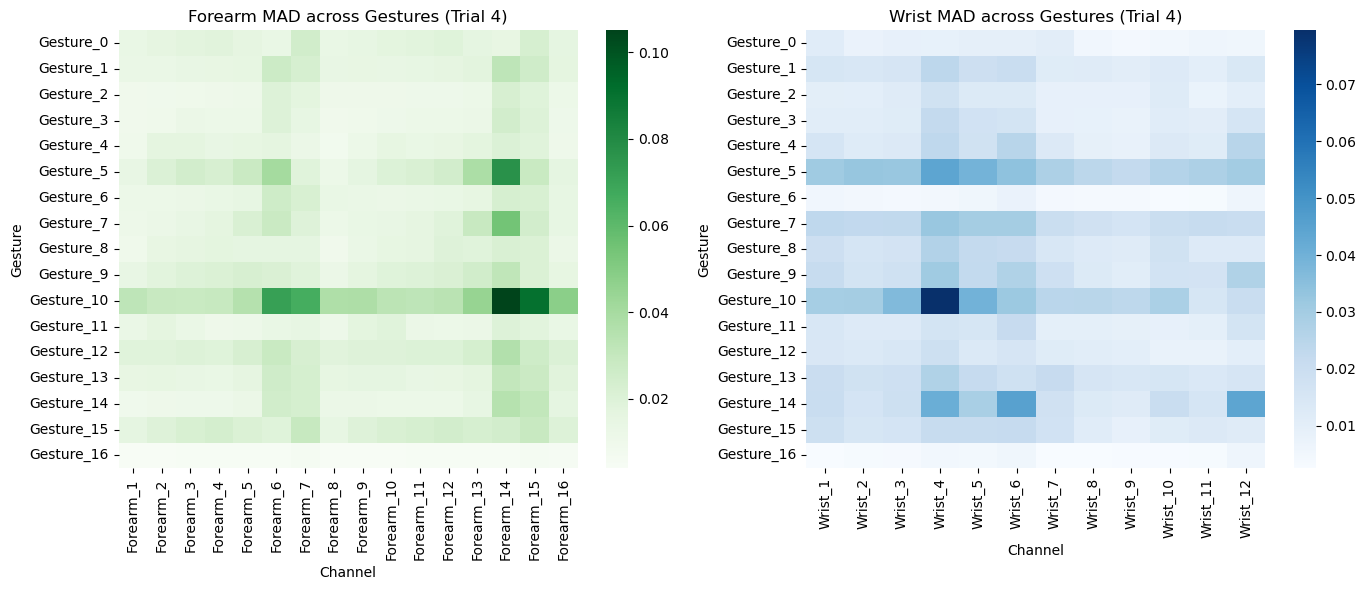

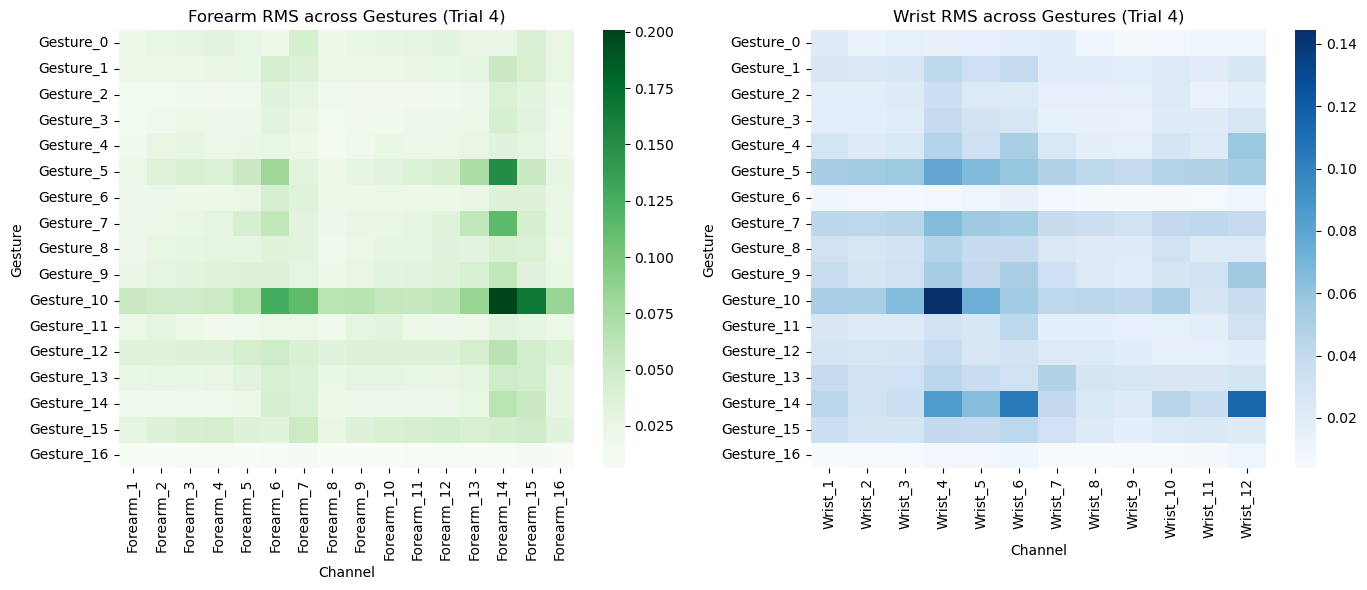

In [8]:
# Heatmap of P5/P95/MAD/RMS across all channels and all gestures for a single trial
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Select the trial to compare (use trial_idx from previous cells)
trial_to_compare = trial_idx  # or set to any valid trial index (0-6)

# Prepare metrics for all gestures and all channels
num_gestures = 17
num_forearm = forearm.shape[1]
num_wrist = wrist.shape[1]
metrics_names = ['P5', 'P95', 'MAD', 'RMS']

# Initialize storage for metrics
forearm_metrics_all = []
wrist_metrics_all = []

for g_idx in range(num_gestures):
    # Load data for this gesture and trial
    forearm_g = data['DATA_FOREARM'][trial_to_compare, g_idx]
    wrist_g = data['DATA_WRIST'][trial_to_compare, g_idx]

    # Compute metrics for each channel
    forearm_metrics_g = [calculate_signal_metrics(forearm_g[:, ch]) for ch in range(num_forearm)]
    wrist_metrics_g = [calculate_signal_metrics(wrist_g[:, ch]) for ch in range(num_wrist)]

    forearm_metrics_all.append(forearm_metrics_g)
    wrist_metrics_all.append(wrist_metrics_g)

# Convert to DataFrames for easier plotting
def metrics_to_df(metrics_all, channel_labels):
    dfs = {}
    for metric in metrics_names:
        arr = np.array([[ch_metrics[metric] for ch_metrics in gesture_metrics] for gesture_metrics in metrics_all])
        df = pd.DataFrame(arr, columns=channel_labels, index=[f'Gesture_{i}' for i in range(num_gestures)])
        dfs[metric] = df
    return dfs

forearm_labels = [f'Forearm_{i+1}' for i in range(num_forearm)]
wrist_labels = [f'Wrist_{i+1}' for i in range(num_wrist)]

forearm_dfs = metrics_to_df(forearm_metrics_all, forearm_labels)
wrist_dfs = metrics_to_df(wrist_metrics_all, wrist_labels)

# Plot heatmaps for each metric
for metric in metrics_names:
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(forearm_dfs[metric], cmap='Greens', annot=False)
    plt.title(f'Forearm {metric} across Gestures (Trial {trial_to_compare+1})')
    plt.xlabel('Channel')
    plt.ylabel('Gesture')

    plt.subplot(1, 2, 2)
    sns.heatmap(wrist_dfs[metric], cmap='Blues', annot=False)
    plt.title(f'Wrist {metric} across Gestures (Trial {trial_to_compare+1})')
    plt.xlabel('Channel')
    plt.ylabel('Gesture')

    plt.tight_layout()
    plt.show()